# Introduction

Analyzing 911 calls data from [Kaggle](https://www.kaggle.com/mchirico/montcoalert). The data contains the following fields:

* lat : String variable, Latitude
* lng: String variable, Longitude
* desc: String variable, Description of the Emergency Call
* zip: String variable, Zipcode
* title: String variable, Title
* timeStamp: String variable, YYYY-MM-DD HH:MM:SS
* twp: String variable, Township
* addr: String variable, Address
* e: String variable, Dummy variable (always 1)

# Contents

1) Data Clean-Up
* Creating columns 'Reasons', 'Issue', and 'Station' based on 'descr' and 'title'
* Droping 'desc','title','twp','addr','e' columns
* Finding missing 'zip' with the help of 'lat' and 'lng'
* Filling missing data of 'Station'
* Creating columns 'Hour','Month','Day of Week', 'Date' from 'timeStamp'

2) Data Analysis
* 911 Calls - Zip Code Distribution on Call Reason
* 911 Calls - Date (Year - Week) of Occurrence on Call Reason
* 911 Calls - Call Issue on Call Reason
* 911 Calls - Total Daily on Call Reason
* 911 Calls - Total Monthly on Call Reason
* 911 Calls - Total Monthly Trend
* 911 Calls - Heatmap of Day Time vs Day of Week
* 911 Calls - Heatmap of Day Time vs Month
* 911 Calls - Total Day Time on Call Reason

In [1]:
import pandas as pd
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# For Notebooks
init_notebook_mode(connected=True)
# For offline use
cf.go_offline()

## 1) Data Clean-Up

In [2]:
df=pd.read_csv('./data//911.csv')
df.head()

,lat,lng,desc,zip,title,timeStamp,twp,addr,e
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:40:00,NEW HANOVER,REINDEER CT & DEAD END,1
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:40:00,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 17:40:00,NORRISTOWN,HAWS AVE,1
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 17:40:01,NORRISTOWN,AIRY ST & SWEDE ST,1
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 17:40:01,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1


In [3]:
def StationFinder(x):
    try:
        return (re.sub('[:]', '', x.split('Station')[1].split(';')[0])).strip()
    except:
        return np.nan           
df['Reason']=df['title'].map(lambda x:(x.split(':')[0]).strip())
df['Issue']=df['title'].map(lambda x:((x.split(':')[1]).split('-')[0]).strip())
df['Station']=df['desc'].map(StationFinder)
df.drop(columns=['desc','title','twp','addr','e'],inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99492 entries, 0 to 99491
Data columns (total 7 columns):
lat          99492 non-null float64
lng          99492 non-null float64
zip          86637 non-null float64
timeStamp    99492 non-null object
Reason       99492 non-null object
Issue        99492 non-null object
Station      63797 non-null object
dtypes: float64(3), object(4)
memory usage: 5.3+ MB


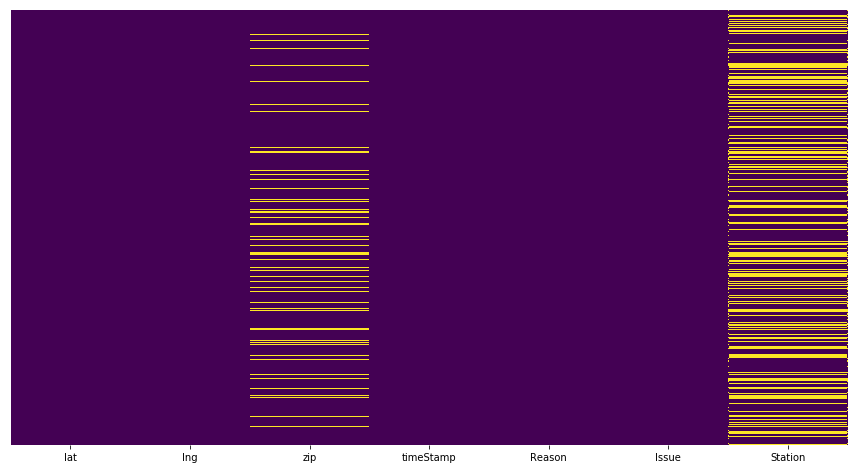

In [4]:
plt.figure(figsize=(15,8))
# heatmap of all missing data
sns.heatmap(df.isna(),cbar=False,yticklabels=False,cmap='viridis')
df.info()

12,855 zipcode missing, but we should be able to find them using longitude and latitude. To get them, we need to do reverse geo coding, followings are the common
reverse geo-coding providers:

    Bing
    Google
    Mapbox
    MapQuest
    What3Words
    HERE
    Yandex
    
geocoder API is a good option to find the zipcode for batched data
https://geocoder.readthedocs.io/providers/Bing.html
To use geocoder a bing account and a an api key is required.
https://msdn.microsoft.com/en-us/library/ff428642.aspx?f=255&MSPPError=-2147217396

In [5]:
# Remove all duplicates for lat lng.
LatLng=df[df['zip'].isna()][['lat','lng']].drop_duplicates()
# Convert them to list to be readable by geocoder
LatLng.to_csv('./data//LatLng.csv',index=False)
LL=LatLng.values.tolist()

Due to limitation of geocode providers, such as google or bing, and their daily limit the option of acquiring zip code using geocoder library is not feasible.

The next option is using another geo-code provider with 15,000 monthly limit. http://more.stevemorse.org/latlonbatch2.html?direction=reverse

All missing zipcodes have been saved to a csv file and using mentioned provider, new csv file was created LatLngAddress.csv

In [6]:
LatLngAddress=pd.read_csv('./data//LatLngAddress.csv')
LLZ=LatLngAddress[['lat','lng','zipcode']]
df['idx']=df.index
df1=df[df['zip'].isna()]
df2=df[~df['zip'].isna()]
df1=pd.merge(left=df1,right=LLZ,how='left',on=['lat','lng'])
df1['zip']=df1['zipcode']
df1.drop(columns=['zipcode'],inplace=True)
df1=df1.append(df2,sort=False).set_index('idx').sort_index()
df1['zip']=df1['zip'].astype('int32')
df1.head()

,lat,lng,zip,timeStamp,Reason,Issue,Station
idx,,,,,,,
0,40.297876,-75.581294,19525,2015-12-10 17:40:00,EMS,BACK PAINS/INJURY,332
1,40.258061,-75.264680,19446,2015-12-10 17:40:00,EMS,DIABETIC EMERGENCY,345
2,40.121182,-75.351975,19401,2015-12-10 17:40:00,Fire,GAS,STA27
3,40.116153,-75.343513,19401,2015-12-10 17:40:01,EMS,CARDIAC EMERGENCY,308A
4,40.251492,-75.603350,19464,2015-12-10 17:40:01,EMS,DIZZINESS,329


<class 'pandas.core.frame.DataFrame'>
Int64Index: 99492 entries, 0 to 99491
Data columns (total 7 columns):
lat          99492 non-null float64
lng          99492 non-null float64
zip          99492 non-null int32
timeStamp    99492 non-null object
Reason       99492 non-null object
Issue        99492 non-null object
Station      63797 non-null object
dtypes: float64(2), int32(1), object(4)
memory usage: 5.7+ MB


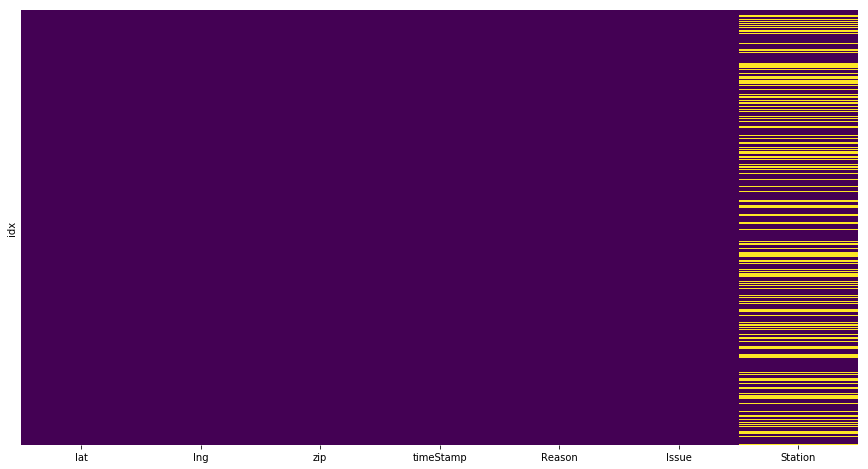

In [7]:
plt.figure(figsize=(15,8))
# heatmap of all missing data
sns.heatmap(df1.isna(),cbar=False,yticklabels=False,cmap='viridis')
df1.info()

The other field with missing data is Station, we now investigate the type of relation between Station and zip code. Station is a function of zip, if and only if for each zip exists only one Station.

In [8]:
print(f"No. Unique Station: {df['Station'].nunique()}")
print(f"No. Unique zip: {df['zip'].nunique()}")

No. Unique Station: 129
No. Unique zip: 104


In [9]:
zS=df1[['zip','Station']].dropna().drop_duplicates()
zS.head()

,zip,Station
idx,,
0,19525,332
1,19446,345
2,19401,STA27
3,19401,308A
4,19464,329


From the head of the data, it can be seen that 19401 had been assigned to 2 stations, so we can not use zip-code to determine station.

In [10]:
df1[df1['Station'].isna()]['Reason'].unique()

array(['Traffic'], dtype=object)

Furthure investigation into the missing data of station shows that, every time the reason was traffic, no station was assigned.

In [11]:
# df1.to_csv('911_clean.csv')

In [12]:
df1['timeStamp']=pd.to_datetime(df1['timeStamp'])
df1['Hour']=df1['timeStamp'].apply(lambda x: x.hour)
df1['Month']=df1['timeStamp'].apply(lambda x: x.month)
df1['Day of Week']=df1['timeStamp'].apply(lambda x: x.dayofweek)
df1['Day of Week']=df1['Day of Week'].map({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'})
df1['Date']=df1['timeStamp'].apply(lambda x: x.date())
df1['Year-Week'] = df1['timeStamp'].dt.strftime('%Y - %U')

In [13]:
df1.head()

,lat,lng,zip,timeStamp,Reason,Issue,Station,Hour,Month,Day of Week,Date,Year-Week
idx,,,,,,,,,,,,
0,40.297876,-75.581294,19525,2015-12-10 17:40:00,EMS,BACK PAINS/INJURY,332,17,12,Thu,2015-12-10,2015 - 49
1,40.258061,-75.264680,19446,2015-12-10 17:40:00,EMS,DIABETIC EMERGENCY,345,17,12,Thu,2015-12-10,2015 - 49
2,40.121182,-75.351975,19401,2015-12-10 17:40:00,Fire,GAS,STA27,17,12,Thu,2015-12-10,2015 - 49
3,40.116153,-75.343513,19401,2015-12-10 17:40:01,EMS,CARDIAC EMERGENCY,308A,17,12,Thu,2015-12-10,2015 - 49
4,40.251492,-75.603350,19464,2015-12-10 17:40:01,EMS,DIZZINESS,329,17,12,Thu,2015-12-10,2015 - 49


## 2) Data Analysis

In [14]:
zipReason_count=df1.groupby(by=['zip','Reason']).count()['Issue'].unstack()
zipReason_count['Sum']=zipReason_count.sum(axis=1)
zipReason_count.sort_values(by=['Sum'],ascending=False,inplace=True)
zipReason_count.drop(columns=['Sum'],inplace=True)

In [15]:
layout={'title':'911 Calls - Zip Code Distribution on Call Reason',
        'bargroupgap':0.1,'width':900,'height':500,
        'titlefont':{'size':12},'barmode':'stack',
        'xaxis':{'tickformat':' ','type':'category','title':'Zip Code','tickfont':{'size':10},'tickangle':45},
        'yaxis':{'title':'Count'}}
zipReason_count.iplot(kind='bar',layout=layout)

In [16]:
df1.groupby(by=['Reason']).nunique()['Station']
Reason=df1.groupby(['Year-Week','Reason']).count()['Issue'].unstack()
layout={'title':'911 Calls - Date of Occurrence on Call Reason',
        'bargroupgap':0.01,'width':900,'height':500,'titlefont':{'size':12},
        'xaxis':{'title':'Year - Week','tickfont':{'size':8}},
        'yaxis':{'title':'Count'}}
Reason.iplot(kind='scatter',mode='lines',layout=layout)

In [17]:
Issues=df1.groupby(['Issue','Reason']).count()['Date'].unstack()
Issues['Sum']=Issues.sum(axis=1)
Issues.sort_values(by=['Sum'],ascending=False,inplace=True)
Issues.drop(columns=['Sum'],inplace=True)

In [18]:
layout={'title':'911 Calls - Call Issue on Call Reason',
        'margin':{'b':100},
        'bargroupgap':0.01,'width':900,'height':500,'titlefont':{'size':12},
        'xaxis':{'tickformat':' ','type':'category','title':'Issue','tickfont':{'size':6.5}},
        'yaxis':{'title':'Count'},'barmode':'stack'}
Issues.iplot(kind='bar',layout=layout)

In [19]:
layout={'title':'911 Calls - Total on Call Reason',
        'bargroupgap':0.1,
        'width':500,'height':500,
        'titlefont':{'size':12},
        'yaxis':{'title':'Count'}}
df1['Reason'].value_counts().to_frame().T.iplot(kind='bar',layout=layout)

In [20]:
Days='Mon Tue Wed Thu Fri Sat Sun'.split()
layout={'title':'911 Calls - Total Daily on Call Reason',
        'bargroupgap':0.1,'width':500,'height':500,
        'titlefont':{'size':12},
        'xaxis':{'title':'Day of Week'},
        'yaxis':{'title':'Count'}}
df1.groupby(['Day of Week','Reason']).count()['Issue'].unstack().reindex(Days).iplot(kind='bar',layout=layout)

In [21]:
layout={'title':'911 Calls - Total Monthly on Call Reason',
        'bargroupgap':0.1,'width':500,'height':500,
        'yaxis':{'title':'Count'},'titlefont':{'size':12},
        'xaxis':{'title':'Month','tickformat':' ','type':'category','tickmode':'linear'}}
df1.groupby(['Month','Reason']).count()['Issue'].unstack().iplot(kind='bar',layout=layout)

In [22]:
byMonth=df1.groupby('Month').count()['Issue'].to_frame()
byMonth.rename(columns={'Issue':'Count'},inplace=True)
Range=byMonth.index
trend=np.polyfit(Range, byMonth['Count'], 1)
lg=trend[1]+trend[0]*Range
LG=f'911 Calls - Total Monthly Trend:   {"%.2f" % trend[0]}*x + {"%.2f" % trend[1]}'
byMonth['Fit']= lg

In [23]:
layout={'title':LG,'width':900,'height':500,
        'xaxis':{'title':'Month','tickmode':'linear'},
        'titlefont':{'size':12},'yaxis':{'title':'Count'}}
byMonth.iplot(kind='scatter',mode = ['markers','lines'],layout=layout)

In [24]:
dayHour = df1.groupby(by=['Day of Week','Hour']).count()['Reason'].unstack()
Days='Mon Tue Wed Thu Fri Sat Sun'.split()
dayHour=dayHour.reindex(Days)

In [25]:
layout={'title':'911 Calls - Heatmap of Day Time vs Day of Week',
        'width':900,'height':800,
        'xaxis':{'title':'Day of Week','tickmode':'auto'},
        'yaxis':{'title':'Hour of Day','tickmode':'linear'}}
dayHour.iplot(kind='heatmap',colorscale='spectral',layout=layout)

In [26]:
monthHour = df1.groupby(by=['Month','Hour']).count()['Reason'].unstack()

In [27]:
layout={'title':'911 Calls - Heatmap of Day Time vs Month',
        'width':900,'height':800,
        'xaxis':{'title':'Month','tickmode':'linear','tickformat':' ','type':'category'},
        'yaxis':{'title':'Hour of Day','tickmode':'linear'}}
monthHour.iplot(kind='heatmap',colorscale='spectral',layout=layout)

In [28]:
layout={'title':'911 Calls - Total Day Time on Call Reason',
        'barmode':'stack','width':900,'height':500,
        'xaxis':{'title':'Hour of Day','tickmode':'linear','tickformat':' ','type':'category'},
        'yaxis':{'title':'Count'}}
df1.groupby(['Hour','Reason']).count()['Issue'].unstack().iplot(kind='bar',layout=layout)